In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/CFL_training_data"

Mounted at /content/drive


In [ ]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(data_path, 'input'))[:1000]:
  input_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'input', image)), (256,256)))
  output_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'output_core', image), cv2.IMREAD_GRAYSCALE), (256,256))/255)
output_images = [image[..., np.newaxis] for image in output_images]

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Add

def conv_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    y = conv_block(x, filters, kernel_size, padding, strides)
    y = conv_block(y, filters, kernel_size, padding, 1)
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same', strides=strides)(x)
    return Add()([x, y])

def build_resunet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    conv1 = residual_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Center
    conv4 = residual_block(pool3, 512)

    # Decoder
    up5 = Concatenate()([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv5 = residual_block(up5, 256)

    up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv2])
    conv6 = residual_block(up6, 128)

    up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv1])
    conv7 = residual_block(up7, 64)

    # Output
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage
model = build_resunet()
model.summary()


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Add

def conv_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    x = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    y = conv_block(x, filters, kernel_size, padding, strides)
    y = conv_block(y, filters, kernel_size, padding, 1)
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same', strides=strides)(x)
    return Add()([x, y])

def build_resunet(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder
    conv1 = residual_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Center
    conv4 = residual_block(pool3, 512)

    # Decoder with skip connections
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = Concatenate()([up5, conv3])
    conv5 = residual_block(up5, 256)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Concatenate()([up6, conv2])
    conv6 = residual_block(up6, 128)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Concatenate()([up7, conv1])
    conv7 = residual_block(up7, 64)

    # Output
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage
model = build_resunet()
model.summary()


In [ ]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01*tf.keras.losses.binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.binary_crossentropy, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
checkpoint_filepath = os.path.join(data_path, "{epoch:02d}-{val_loss:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
model.fit(x=np.array(input_images),
    y=np.array(output_images),
    validation_split=0.2,
    batch_size=8,
    epochs=30,
    callbacks=[model_checkpoint_callback],
    shuffle=False)

Epoch 1/30
  1/100 [..............................] - ETA: 1:43:01 - loss: 15.8445 - dice_coef: 0.3987 - binary_accuracy: 0.2693 - true_positive_rate: 0.7546

KeyboardInterrupt: 

In [ ]:
model.save(os.path.join(data_path, 'final_resunet_model_30_ep.hdf5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pred = model.predict(np.array(input_images[:5]))

1/1 [==============================] - 7s 7s/step


In [ ]:
print(pred)

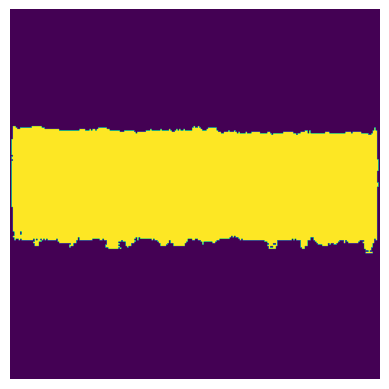

In [ ]:
plt.imshow(pred[0]>0.8)
plt.axis('off')
plt.show()